# Reinforcement Learning 2025 - Midterm Assignment

**Authors:** Gal Yaacov Noy, Amit Ezer.

**Goal:** Implement and compare SARSA and Double Q-Learning agents in a dynamic obstacle environment.  

In [2]:
!pip install minigrid gymnasium matplotlib

In [3]:
import os
import numpy as np
import gymnasium as gym
import itertools
import minigrid
import matplotlib.pyplot as plt
from collections import defaultdict
import pickle

np.random.seed(42)

In [4]:
def get_state(obs):
    """Convert observation to a hashable state key."""
    return (obs["direction"], tuple(obs["image"].flatten()))

In [5]:
def init_q_table(env, random_init=False):
    """
    Initialize Q-table with zeros or random values.
    """
    if random_init:
        return defaultdict(lambda: np.random.uniform(-0.01, 0.01, env.action_space.n))
    else:
        return defaultdict(lambda: np.zeros(env.action_space.n))

In [6]:
def get_reward(obs, reward, use_reward_shaping=False):
    """
    Returns the reward, optionally adding a bonus for proximity to the goal.
    """
    if use_reward_shaping:
        for i in range(7):
            for j in range(7):
                if obs["image"][i][j][0] == 8:  # Goal found
                    dist = abs(i - 3) + abs(j - 3)  # Manhattan distance from agent center
                    return reward + 1 / (dist + 1)  # Closer = higher bonus
    return reward

In [7]:
def epsilon_greedy_action(state, q_func, epsilon, action_space):
    """Select an action using an epsilon-greedy policy."""
    if np.random.rand() < epsilon:
        return action_space.sample()
    return int(np.argmax(q_func(state)))

def log_episode(logs, reward, steps, success):
    """Store training statistics for later analysis."""
    logs["rewards"].append(reward)
    logs["steps"].append(steps)
    logs["successes"].append(int(success))

In [8]:
def train_agent(
    env,
    agent_name,
    num_episodes=5000,
    alpha=0.1,
    gamma=0.99,
    epsilon_start=1.0,
    epsilon_min=0.05,
    epsilon_decay=0.995,
    random_q_init=False,
    use_reward_shaping=False,
):
    
    # Validate hyperparameters
    assert 0 < alpha <= 1, "Learning rate must be in (0, 1]"
    assert 0 <= gamma <= 1, "Discount factor must be in [0, 1]"
    assert 0 < epsilon_decay < 1, "Epsilon decay must be in (0, 1)"
    assert 0 <= epsilon_min <= epsilon_start <= 1, "Epsilon values must be valid"
    
    q1 = init_q_table(env, random_q_init)
    q2 = init_q_table(env, random_q_init) if agent_name == "Double Q-Learning" else None

    logs = {"rewards": [], "steps": [], "successes": []}
    epsilon = epsilon_start

    for episode in range(num_episodes):
        obs, _ = env.reset()
        state = get_state(obs)

        # Initial Q-function for action selection
        q_func = lambda s: q1[s] + q2[s] if q2 else q1[s]
        action = epsilon_greedy_action(state, q_func, epsilon, env.action_space)

        total_reward, steps = 0, 0
        terminated = truncated = False

        while not (terminated or truncated):
            next_obs, reward, terminated, truncated, _ = env.step(action)
            reward = get_reward(next_obs, reward, use_reward_shaping)
            next_state = get_state(next_obs)
            done = terminated or truncated
            total_reward += reward
            steps += 1

            if agent_name == "SARSA":
                next_action = epsilon_greedy_action(next_state, lambda s: q1[s], epsilon, env.action_space)
                td_target = reward + gamma * q1[next_state][next_action] * (not done)
                q1[state][action] += alpha * (td_target - q1[state][action])
                action = next_action

            else:  # Double Q-Learning
                use_q1 = np.random.rand() < 0.5
                q_main, q_other = (q1, q2) if use_q1 else (q2, q1)

                a_max = np.argmax(q_main[next_state])
                td_target = reward + gamma * q_other[next_state][a_max] * (not done)
                q_main[state][action] += alpha * (td_target - q_main[state][action])

                # Use combined Q1 + Q2 to select next action
                action = epsilon_greedy_action(next_state, lambda s: q1[s] + q2[s], epsilon, env.action_space)

            state = next_state

        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        log_episode(logs, total_reward, steps, reward > 0)

        if episode % 100 == 0:
            print(f"[{agent_name}] Ep {episode} - reward: {total_reward:.2f}, steps: {steps}, success: {reward > 0}")

    return q1, q2, logs

In [ ]:
def plot_results(sarsa_logs, dq_logs, window=100, title="Training Results"):
    """Plot training results."""
    def moving_average(data, window):
        return np.convolve(data, np.ones(window)/window, mode='valid')

    _, axs = plt.subplots(1, 3, figsize=(15, 4), sharex=False)
    plt.suptitle(title, fontsize=16)

    metrics = [
        ("rewards", "Average Reward", "Reward"),
        ("steps", "Episode Length", "Steps"),
        ("successes", "Success Rate", "Success Rate")
    ]

    for i, (metric, title_text, ylabel) in enumerate(metrics):
        axs[i].plot(moving_average(sarsa_logs[metric], window), label="SARSA", linewidth=2)
        axs[i].plot(moving_average(dq_logs[metric], window), label="Double Q-Learning", linewidth=2)
        axs[i].set_title(title_text)
        axs[i].set_ylabel(ylabel)
        axs[i].legend()
        axs[i].grid(alpha=0.3)
        if i == 1:  # Middle plot gets x-label
            axs[i].set_xlabel("Episode")

    plt.tight_layout()
    plt.show()

def print_performance_summary(sarsa_logs, dq_logs, mode_name):
    """Print performance summary for the current mode."""
    print(f"\n{'='*60}")
    print(f"PERFORMANCE SUMMARY - {mode_name.upper()}")
    print(f"{'='*60}")
    
    # Calculate metrics for both algorithms
    def get_metrics(logs):
        final_success = np.mean(logs["successes"][-100:]) * 100
        best_success = max([np.mean(logs["successes"][i:i+100]) * 100 
                           for i in range(len(logs["successes"])-99)])
        final_reward = np.mean(logs["rewards"][-100:])
        final_steps = np.mean(logs["steps"][-100:])
        return final_success, best_success, final_reward, final_steps
    
    sarsa_metrics = get_metrics(sarsa_logs)
    dq_metrics = get_metrics(dq_logs)
    
    # Print results
    for name, metrics in [("SARSA", sarsa_metrics), ("Double Q-Learning", dq_metrics)]:
        final_success, best_success, final_reward, final_steps = metrics
        print(f"{name} Results:")
        print(f"  Final Success Rate: {final_success:.1f}% | Best: {best_success:.1f}%")
        print(f"  Final Reward: {final_reward:.3f} | Final Steps: {final_steps:.1f}")
    
    # Winner determination
    winner = "SARSA" if sarsa_metrics[0] > dq_metrics[0] else "Double Q-Learning"
    margin = abs(sarsa_metrics[0] - dq_metrics[0])
    print(f"\nWinner: {winner} (by {margin:.1f}%)")
    print(f"{'='*60}")

def save_policies(sarsa_q, double_q1, double_q2, mode="baseline"):
    """
    Save Q-tables into a subfolder under 'policies/' named after the mode.
    For example: policies/baseline/sarsa_q.pkl
    """
    print(f"\nSaving Q-tables for mode: {mode}")
    
    folder = os.path.join("policies", mode)
    os.makedirs(folder, exist_ok=True)

    policies = {
        "sarsa_q": sarsa_q,
        "double_q1": double_q1,
        "double_q2": double_q2
    }

    for name, q_table in policies.items():
        path = os.path.join(folder, f"{name}.pkl")
        with open(path, 'wb') as f:
            pickle.dump(dict(q_table), f)
            
    print(f"Q-tables saved to: {folder}")

def run_experiment(env, config_name, **kwargs):
    """Run complete experiment: train both agents, analyze, plot, and save."""
    print(f"\n{'='*60}")
    print(f"RUNNING EXPERIMENT: {config_name.upper()}")
    print(f"{'='*60}")
    
    # Train both agents
    print("Training SARSA...")
    sarsa_q, _, sarsa_logs = train_agent(env, "SARSA", **kwargs)
    
    print("Training Double Q-Learning...")
    dq_q1, dq_q2, dq_logs = train_agent(env, "Double Q-Learning", **kwargs)
    
    # Analyze and visualize
    print_performance_summary(sarsa_logs, dq_logs, config_name)
    plot_results(sarsa_logs, dq_logs, title=config_name)
    
    # Save policies
    mode = config_name.lower().replace(" ", "_").replace("-", "_")
    save_policies(sarsa_q, dq_q1, dq_q2, mode)
    
    return sarsa_logs, dq_logs


RUNNING EXPERIMENT: BASELINE
Training SARSA...
[SARSA] Ep 0 - reward: -1.00, steps: 2, success: False
[SARSA] Ep 100 - reward: -1.00, steps: 4, success: False
[SARSA] Ep 200 - reward: -1.00, steps: 43, success: False
[SARSA] Ep 300 - reward: -1.00, steps: 92, success: False
[SARSA] Ep 400 - reward: 0.00, steps: 144, success: False
[SARSA] Ep 500 - reward: -1.00, steps: 86, success: False
[SARSA] Ep 600 - reward: 0.00, steps: 144, success: False
[SARSA] Ep 700 - reward: -1.00, steps: 85, success: False
[SARSA] Ep 800 - reward: -1.00, steps: 68, success: False
[SARSA] Ep 900 - reward: -1.00, steps: 4, success: False
[SARSA] Ep 1000 - reward: 0.00, steps: 144, success: False
[SARSA] Ep 1100 - reward: -1.00, steps: 26, success: False
[SARSA] Ep 1200 - reward: 0.36, steps: 102, success: True
[SARSA] Ep 1300 - reward: 0.00, steps: 144, success: False
[SARSA] Ep 1400 - reward: -1.00, steps: 32, success: False
[SARSA] Ep 1500 - reward: 0.00, steps: 144, success: False
[SARSA] Ep 1600 - reward

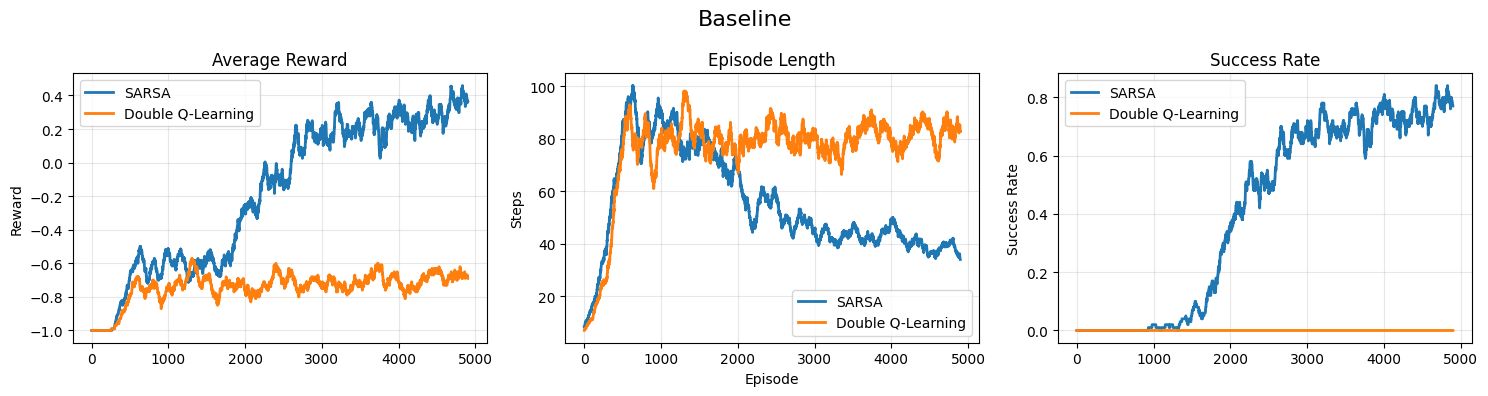

Q-tables saved to: policies/baseline

RUNNING EXPERIMENT: RANDOM Q-INIT
Training SARSA...
[SARSA] Ep 0 - reward: -1.00, steps: 3, success: False
[SARSA] Ep 100 - reward: -1.00, steps: 4, success: False
[SARSA] Ep 200 - reward: -1.00, steps: 17, success: False
[SARSA] Ep 300 - reward: -1.00, steps: 3, success: False
[SARSA] Ep 400 - reward: -1.00, steps: 29, success: False
[SARSA] Ep 500 - reward: -1.00, steps: 3, success: False
[SARSA] Ep 600 - reward: -1.00, steps: 57, success: False
[SARSA] Ep 700 - reward: -1.00, steps: 53, success: False
[SARSA] Ep 800 - reward: -1.00, steps: 39, success: False
[SARSA] Ep 900 - reward: -1.00, steps: 43, success: False
[SARSA] Ep 1000 - reward: -1.00, steps: 21, success: False
[SARSA] Ep 1100 - reward: -1.00, steps: 28, success: False
[SARSA] Ep 1200 - reward: -1.00, steps: 34, success: False
[SARSA] Ep 1300 - reward: -1.00, steps: 49, success: False
[SARSA] Ep 1400 - reward: -1.00, steps: 35, success: False
[SARSA] Ep 1500 - reward: 0.77, steps: 37

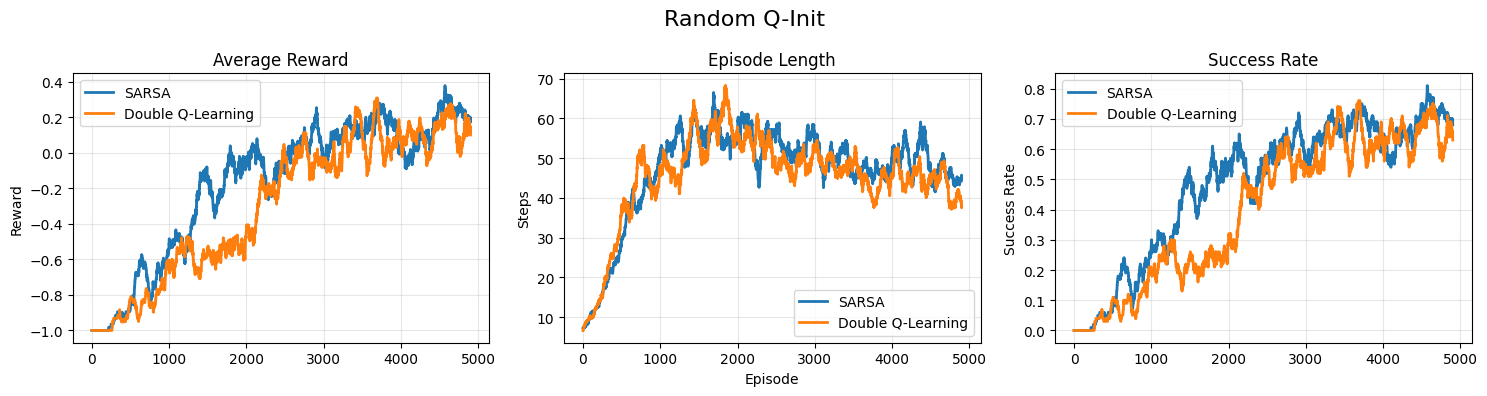

Q-tables saved to: policies/random_q_init

RUNNING EXPERIMENT: REWARD SHAPING
Training SARSA...
[SARSA] Ep 0 - reward: -1.00, steps: 3, success: False
[SARSA] Ep 100 - reward: -1.00, steps: 2, success: False
[SARSA] Ep 200 - reward: 0.75, steps: 14, success: False
[SARSA] Ep 300 - reward: 2.07, steps: 15, success: False
[SARSA] Ep 400 - reward: 3.27, steps: 29, success: False
[SARSA] Ep 500 - reward: 14.98, steps: 57, success: True
[SARSA] Ep 600 - reward: 3.68, steps: 26, success: False
[SARSA] Ep 700 - reward: 24.30, steps: 86, success: False
[SARSA] Ep 800 - reward: -0.10, steps: 4, success: False
[SARSA] Ep 900 - reward: 37.11, steps: 105, success: True
[SARSA] Ep 1000 - reward: 15.93, steps: 43, success: True
[SARSA] Ep 1100 - reward: 30.28, steps: 126, success: False
[SARSA] Ep 1200 - reward: 12.83, steps: 51, success: True
[SARSA] Ep 1300 - reward: 26.91, steps: 144, success: True
[SARSA] Ep 1400 - reward: 6.02, steps: 38, success: False
[SARSA] Ep 1500 - reward: 1.52, steps: 16

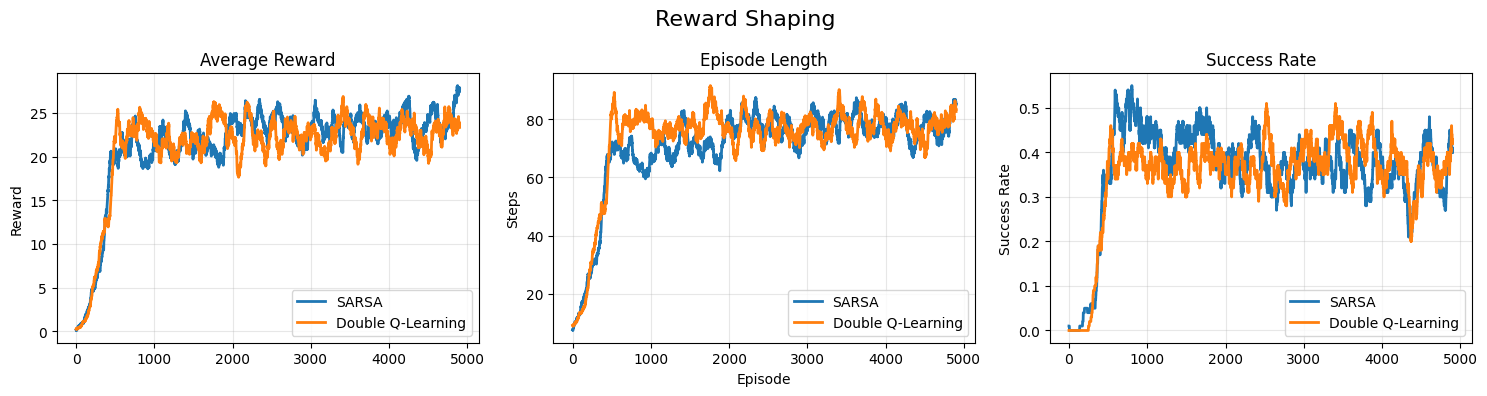

Q-tables saved to: policies/reward_shaping

RUNNING EXPERIMENT: RANDOM Q-INIT + REWARD SHAPING
Training SARSA...
[SARSA] Ep 0 - reward: 4.05, steps: 19, success: False
[SARSA] Ep 100 - reward: 1.48, steps: 14, success: False
[SARSA] Ep 200 - reward: 0.12, steps: 4, success: False
[SARSA] Ep 300 - reward: 0.87, steps: 10, success: False
[SARSA] Ep 400 - reward: 1.96, steps: 10, success: False
[SARSA] Ep 500 - reward: 9.40, steps: 42, success: True
[SARSA] Ep 600 - reward: 13.60, steps: 39, success: True
[SARSA] Ep 700 - reward: 1.57, steps: 12, success: False
[SARSA] Ep 800 - reward: 0.85, steps: 10, success: False
[SARSA] Ep 900 - reward: 0.92, steps: 10, success: False
[SARSA] Ep 1000 - reward: 7.87, steps: 33, success: True
[SARSA] Ep 1100 - reward: 2.01, steps: 12, success: False
[SARSA] Ep 1200 - reward: 16.30, steps: 65, success: True
[SARSA] Ep 1300 - reward: 1.57, steps: 14, success: False
[SARSA] Ep 1400 - reward: 7.33, steps: 37, success: False
[SARSA] Ep 1500 - reward: 3.88, 

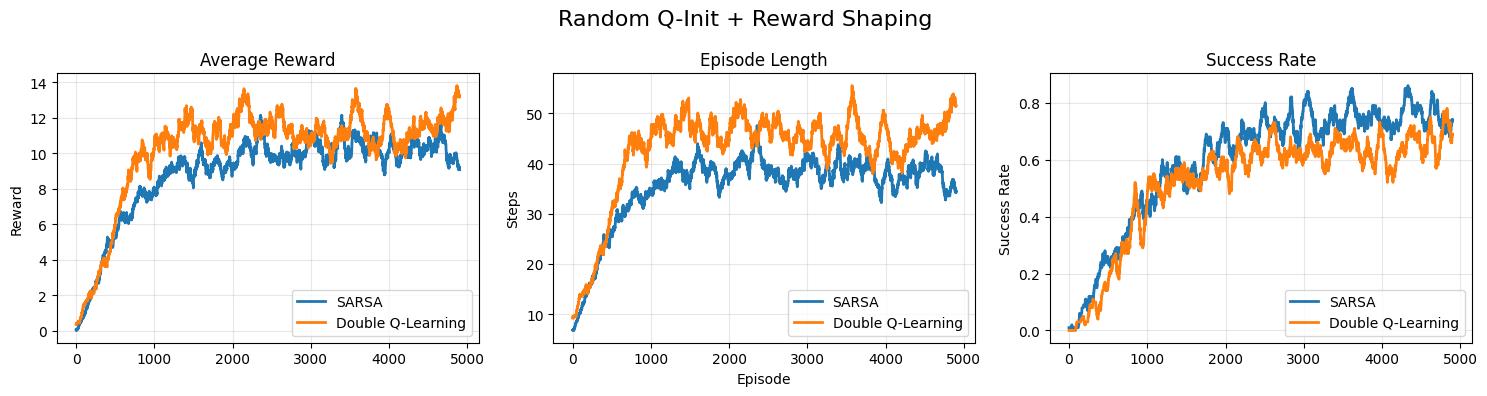

Q-tables saved to: policies/random_q_init_+_reward_shaping

ALL EXPERIMENTS COMPLETED!


In [10]:
# Run all experiments
env = gym.make("MiniGrid-Dynamic-Obstacles-6x6-v0")

# Experiment configurations
experiments = [
    ("Baseline", {}),
    ("Random Q-Init", {"random_q_init": True}),
    ("Reward Shaping", {"use_reward_shaping": True}),
    ("Random Q-Init + Reward Shaping", {"random_q_init": True, "use_reward_shaping": True})
]

# Store results for comparison
all_results = {}
for config_name, config_params in experiments:
    sarsa_logs, dq_logs = run_experiment(env, config_name, **config_params)
    all_results[config_name] = {"sarsa": sarsa_logs, "dq": dq_logs}

print("\n" + "="*80)
print("ALL EXPERIMENTS COMPLETED!")
print("="*80)

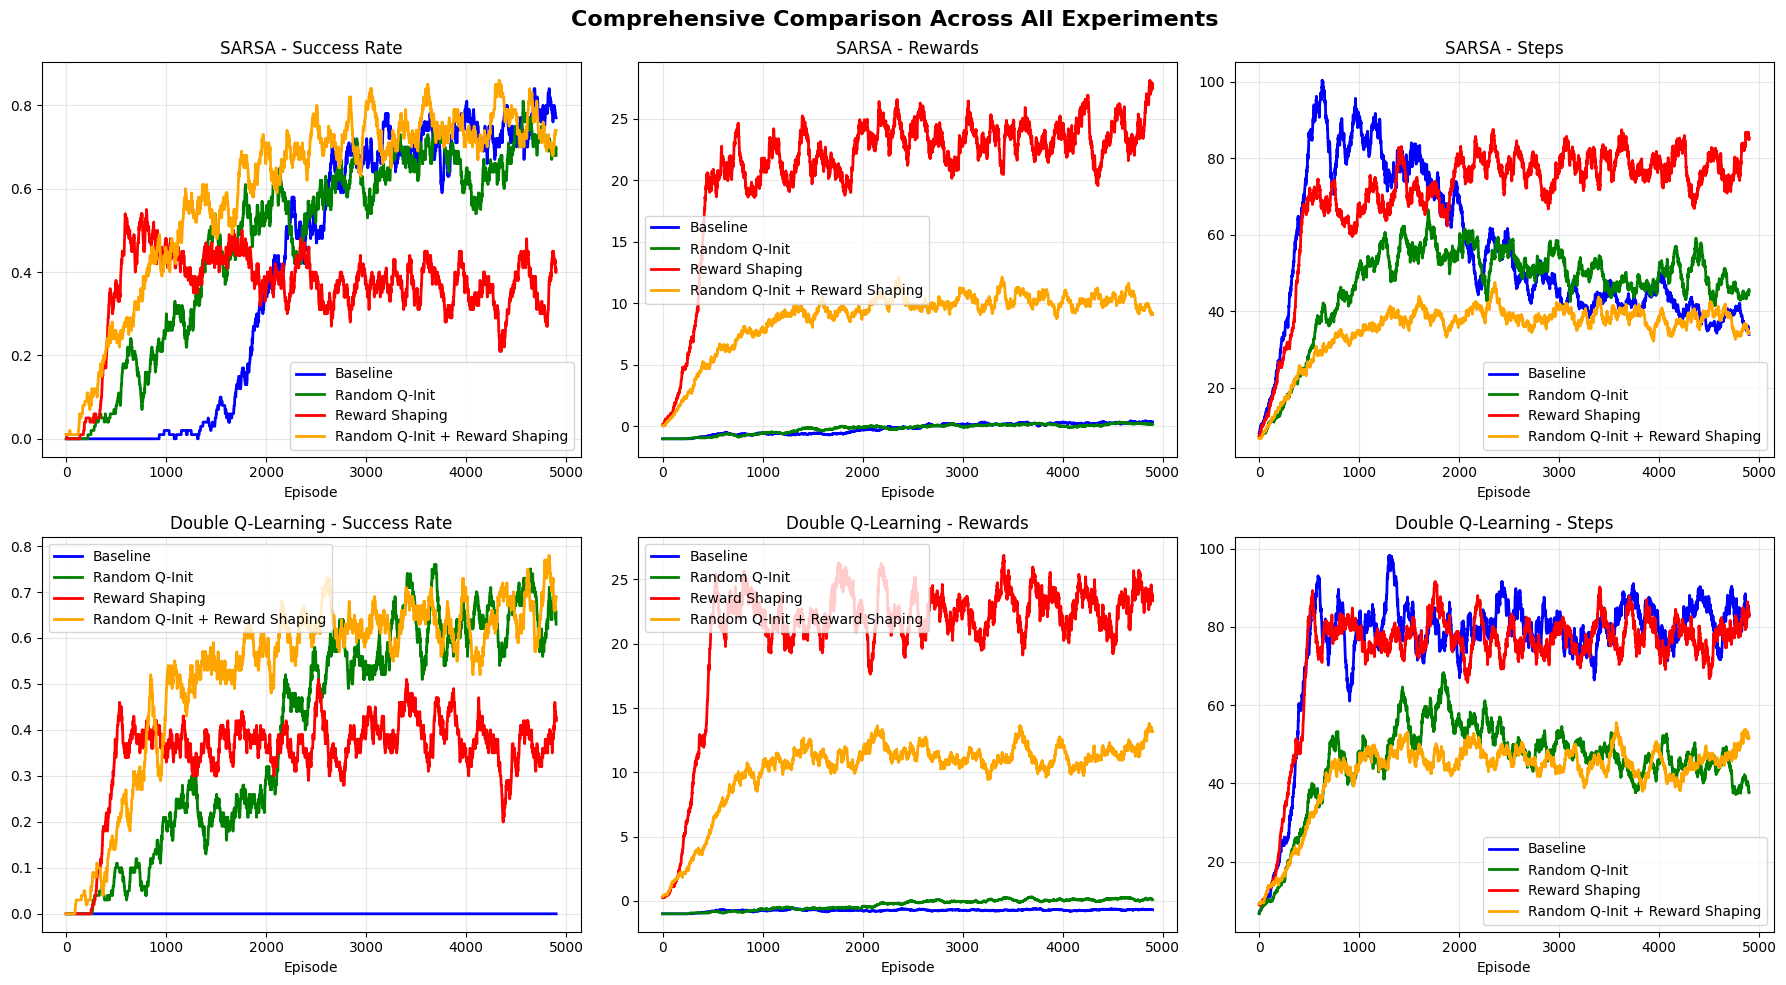


FINAL PERFORMANCE COMPARISON TABLE
Configuration                   Algorithm           Final Success %  Best Success %   Final Reward     Final Steps  
--------------------------------------------------------------------------------------------------------------------
Baseline                         SARSA                77.0              84.0              0.363             34.0         
Baseline                         Double Q-Learning    0.0               0.0               -0.690            82.9         
Random Q-Init                    SARSA                68.0              81.0              0.176             45.3         
Random Q-Init                    Double Q-Learning    63.0              76.0              0.100             37.6         
Reward Shaping                   SARSA                40.0              55.0              27.644            85.2         
Reward Shaping                   Double Q-Learning    42.0              51.0              23.338            82.7        

: 

In [ ]:
# Final Comprehensive Analysis
def plot_all_experiments_comparison(all_results):
    """Plot comparison across all experiment configurations."""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle("Comprehensive Comparison Across All Experiments", fontsize=16, fontweight='bold')
    
    def moving_average(data, window=100):
        return np.convolve(data, np.ones(window)/window, mode='valid')
    
    colors = ['blue', 'green', 'red', 'orange']
    
    # Plot SARSA results
    for i, (config, color) in enumerate(zip(all_results.keys(), colors)):
        sarsa_logs = all_results[config]["sarsa"]
        
        # Success rate
        axes[0, 0].plot(moving_average(sarsa_logs["successes"]), 
                       label=config, color=color, linewidth=2)
        # Rewards
        axes[0, 1].plot(moving_average(sarsa_logs["rewards"]), 
                       label=config, color=color, linewidth=2)
        # Steps
        axes[0, 2].plot(moving_average(sarsa_logs["steps"]), 
                       label=config, color=color, linewidth=2)
    
    # Plot Double Q-Learning results
    for i, (config, color) in enumerate(zip(all_results.keys(), colors)):
        dq_logs = all_results[config]["dq"]
        
        # Success rate
        axes[1, 0].plot(moving_average(dq_logs["successes"]), 
                       label=config, color=color, linewidth=2)
        # Rewards
        axes[1, 1].plot(moving_average(dq_logs["rewards"]), 
                       label=config, color=color, linewidth=2)
        # Steps
        axes[1, 2].plot(moving_average(dq_logs["steps"]), 
                       label=config, color=color, linewidth=2)
    
    # Configure subplots
    titles = [["SARSA - Success Rate", "SARSA - Rewards", "SARSA - Steps"],
              ["Double Q-Learning - Success Rate", "Double Q-Learning - Rewards", "Double Q-Learning - Steps"]]
    
    for i in range(2):
        for j in range(3):
            axes[i, j].set_title(titles[i][j])
            axes[i, j].legend()
            axes[i, j].grid(alpha=0.3)
            axes[i, j].set_xlabel("Episode")
    
    plt.tight_layout()
    plt.show()
    
def final_performance_table(all_results):
    """Print a clean, left-aligned performance summary table."""
    headers = ["Configuration", "Algorithm", "Final Success %", "Best Success %", "Final Reward", "Final Steps"]
    col_widths = [32, 20, 17, 17, 17, 13]
    total_width = sum(col_widths)

    # Format headers (all left-aligned)
    header_fmt = "".join([f"{{:<{w}}}" for w in col_widths])
    row_fmt = (
        f"{{:<{col_widths[0]}}} "  # Configuration
        f"{{:<{col_widths[1]}}} "  # Algorithm
        f"{{:<{col_widths[2]}.1f}} "  # Final Success %
        f"{{:<{col_widths[3]}.1f}} "  # Best Success %
        f"{{:<{col_widths[4]}.3f}} "  # Final Reward
        f"{{:<{col_widths[5]}.1f}}"   # Final Steps
    )

    print("\n" + "=" * total_width)
    print("FINAL PERFORMANCE COMPARISON TABLE")
    print("=" * total_width)
    print(header_fmt.format(*headers))
    print("-" * total_width)

    best_configs = {}

    for config_name, results in all_results.items():
        for alg_name, alg_key in [("SARSA", "sarsa"), ("Double Q-Learning", "dq")]:
            logs = results[alg_key]
            final_success = np.mean(logs["successes"][-100:]) * 100
            best_success = max([
                np.mean(logs["successes"][i:i+100]) * 100
                for i in range(len(logs["successes"]) - 99)
            ])
            final_reward = np.mean(logs["rewards"][-100:])
            final_steps = np.mean(logs["steps"][-100:])

            print(row_fmt.format(
                config_name, alg_name, final_success, best_success, final_reward, final_steps
            ))

            best_configs[f"{config_name} + {alg_name}"] = final_success

    best_config = max(best_configs, key=best_configs.get)
    best_score = best_configs[best_config]

    print("-" * total_width)
    print(f"OVERALL BEST CONFIGURATION: {best_config} with {best_score:.1f}% success rate")
    print("=" * total_width)


# Run final analysis
plot_all_experiments_comparison(all_results)
final_performance_table(all_results)

# Save all results for future analysis
with open("experiment_results.pkl", "wb") as f:
    pickle.dump(all_results, f)

print("\nAll experiment results saved to 'experiment_results.pkl'")
print("Q-tables saved in 'policies/' directory")
print("\nExperiment complete!")

## Final Experiment: Best Configuration on 8x8 Environment

Now we'll test the best-performing configuration from our experiments on a larger, more challenging 8x8 environment to evaluate how well our learning scales.


RUNNING EXPERIMENT: 8X8 DYNAMIC OBSTACLES
Training SARSA...
[SARSA] Ep 0 - reward: -1.00, steps: 5, success: False
[SARSA] Ep 100 - reward: -1.00, steps: 21, success: False
[SARSA] Ep 200 - reward: -0.67, steps: 22, success: False
[SARSA] Ep 300 - reward: -1.00, steps: 4, success: False
[SARSA] Ep 400 - reward: -1.00, steps: 7, success: False
[SARSA] Ep 500 - reward: 4.13, steps: 63, success: False
[SARSA] Ep 600 - reward: -1.00, steps: 2, success: False
[SARSA] Ep 700 - reward: -1.00, steps: 18, success: False
[SARSA] Ep 800 - reward: -0.30, steps: 9, success: False
[SARSA] Ep 900 - reward: -0.47, steps: 11, success: False
[SARSA] Ep 1000 - reward: 7.23, steps: 66, success: True
[SARSA] Ep 1100 - reward: 7.82, steps: 85, success: False
[SARSA] Ep 1200 - reward: 0.57, steps: 48, success: False
[SARSA] Ep 1300 - reward: 2.73, steps: 57, success: False
[SARSA] Ep 1400 - reward: -1.00, steps: 10, success: False
[SARSA] Ep 1500 - reward: -1.00, steps: 2, success: False
[SARSA] Ep 1600 - r

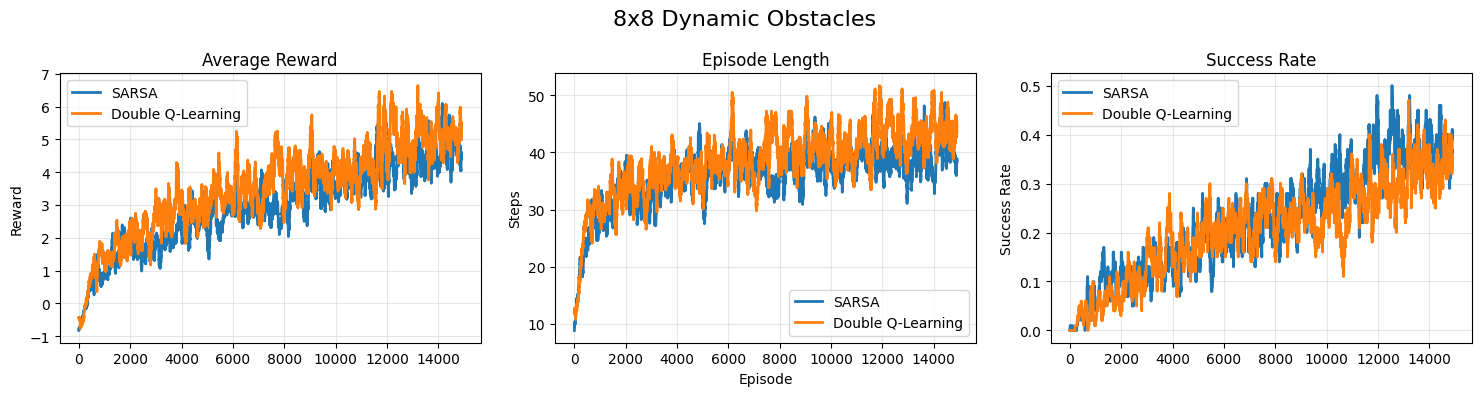

In [ ]:
env = gym.make("MiniGrid-Dynamic-Obstacles-8x8-v0")

# Train SARSA and Double Q-Learning on the 8x8 environment
sarsa_logs, dq_logs = run_experiment(env, "8x8 Dynamic Obstacles", num_episodes=15000, random_q_init=True, use_reward_shaping=True)